# Project: China Scientific Leadership

**Notebook:** Fig4b_China_International_students_statistics_by_Regions.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure 4b** for the main text. The data are drawn from concise statistics on international students in China during the period 2006–2018.

**Inputs:**
- `data/China_international_student_statistics_by_regions.csv`

**Outputs:**
- `pics/fig_4_b.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time
import sys

In [2]:
# Load the saved data
df_intl_sta = pd.read_csv( "./data/China_international_student_statistics_by_regions.csv", encoding="utf-8")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), df_intl_sta.shape)
df_intl_sta.head(2)

 6:41AM CDT on Sep 17, 2025 (15, 14)


,region,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,South Asia,33444.0,42174.0,48512.0,57505.0,67655.0,74660.0,83981.0,94435.0,100263.0,109261.0,125153.0,150850.0,164451.0
1,Africa,0.0,0.0,1116.0,3568.0,7655.0,12666.0,18936.0,25826.0,35163.0,44151.0,56135.0,69144.0,77555.0


In [3]:
# Split into the two parts based on region labels
df_br = df_intl_sta[df_intl_sta["region"].isin(["BeltRoad_HighIncome", "BeltRoad_LowIncome"])].copy()
df_region = df_intl_sta[~df_intl_sta["region"].isin(["BeltRoad_HighIncome", "BeltRoad_LowIncome"])].copy()
# Index df_region by region
df_region = df_region.set_index("region")
df_br.shape, df_region.shape

((2, 14), (13, 13))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import to_rgba

# -------- Colors --------
hue_colors = {
    "U.S.":"#1f77b4", "U.K.":"#fdc086", "EU+":"#1b9e77",
    "China":"#e31a1c", "Russia":"#fb9a99",
    "Middle East": "#ff7f00", "South Asia": "#ade8f4",
    "Latin America": "#7570b3", "Middle East North Africa":"#B4A582",
    "Non-EU Eastern Europe":"#217D33", "Africa":"#B2A871",
    "Central Asia":"#9e2a2b", "East Asia":"#0096c7",
    "Other Regions":"#91989F",
    "BeltRoad_HighIncome": "#f25c54", "BeltRoad_LowIncome": "#ffb703"
}
# Ensure every region has a color
for r in list(df_region.index.unique()) + list(df_br.index.unique()):
    if r not in hue_colors:
        hue_colors[r] = "#5DAC81"

/scratch/local/jobs/36968074/ipykernel_2878399/2350111637.py:64: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for text, handle in zip(lg.get_texts(), lg.legendHandles):


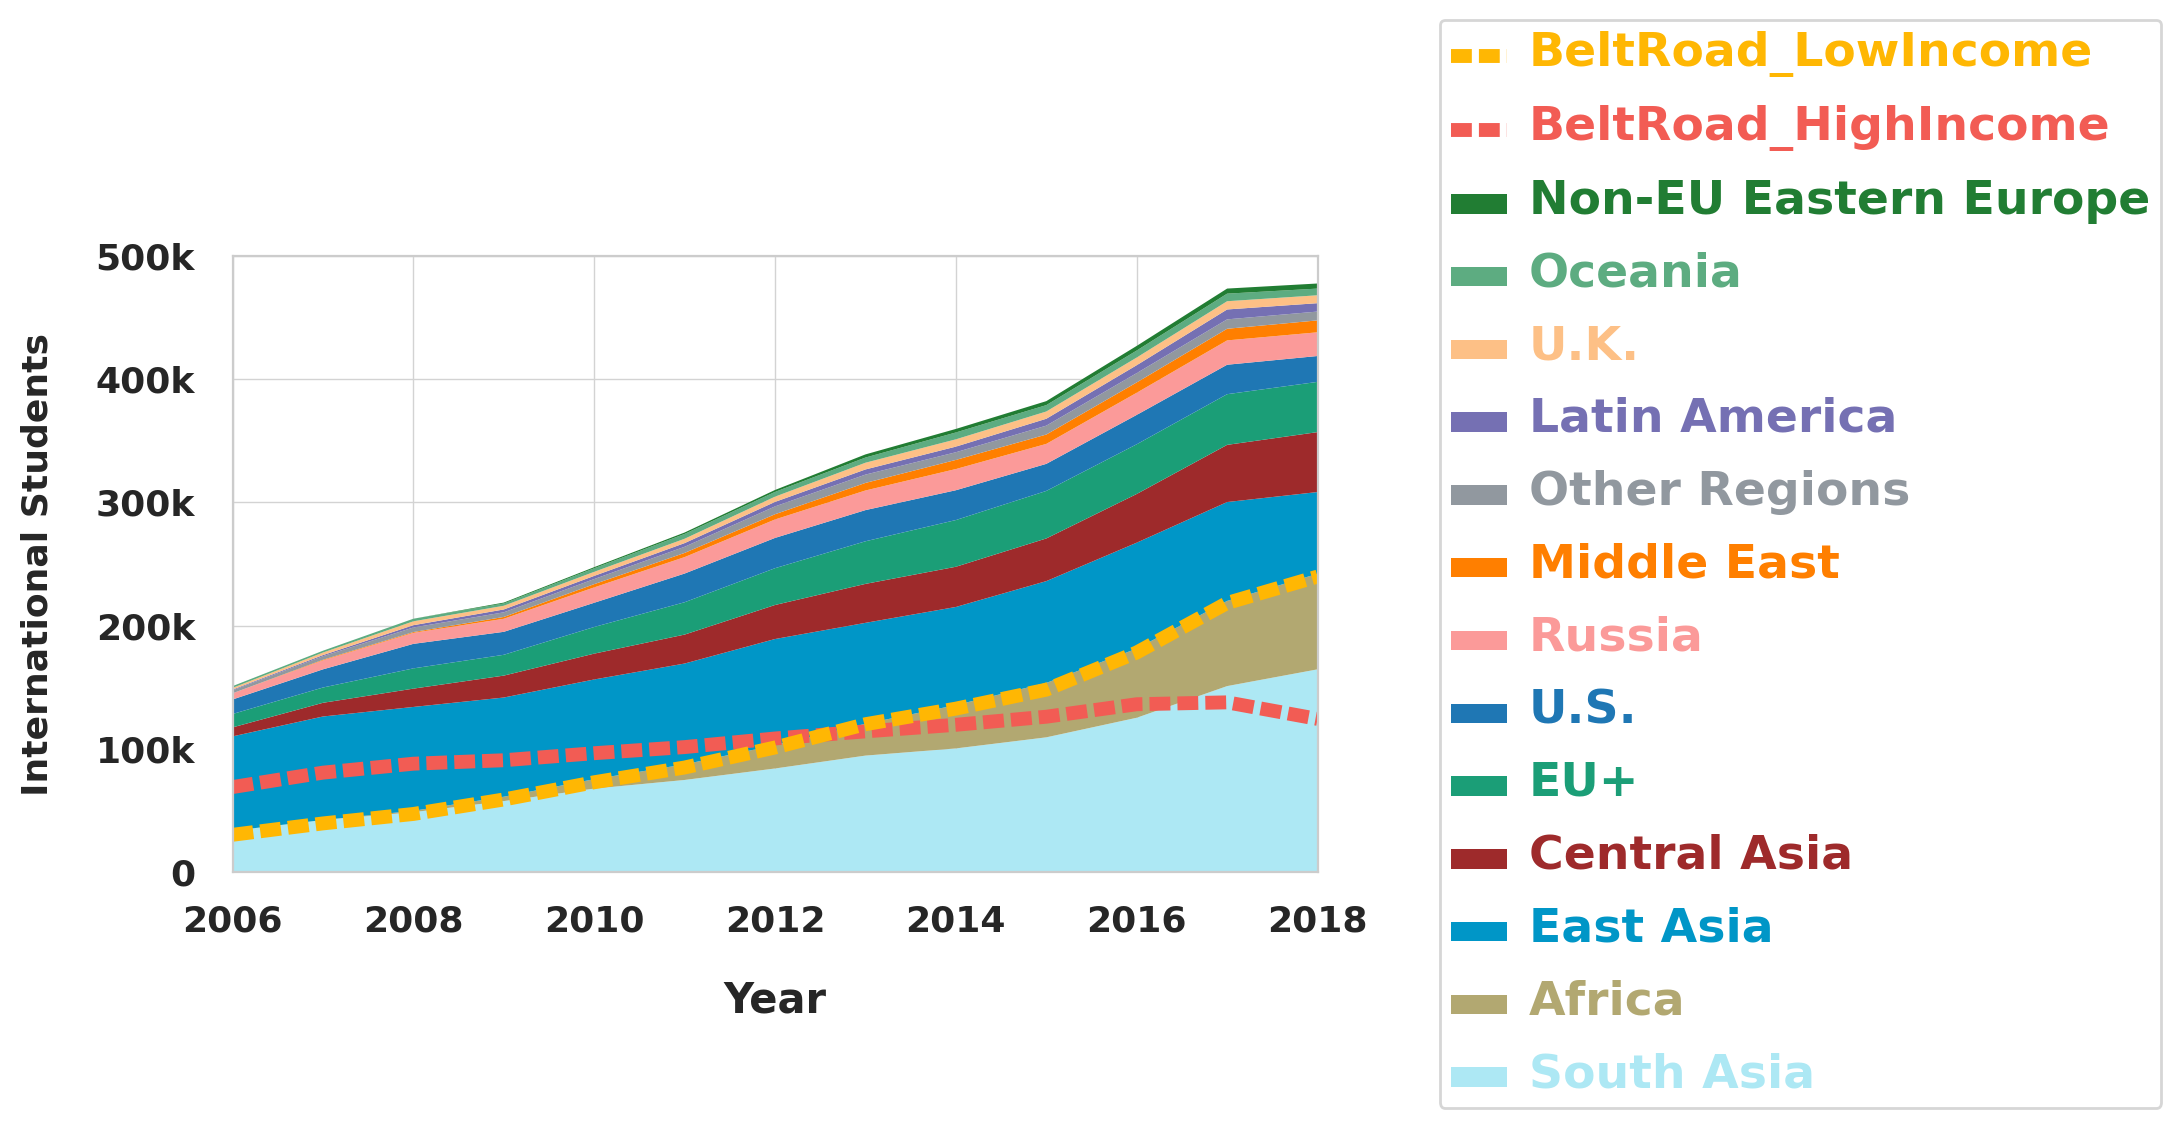

In [5]:
# --- Style & preparation ---
sns.set_style("whitegrid")
# Year columns (exclude 'region')
year_cols = [c for c in df_region.columns if c != "region"]
years = sorted(map(int, year_cols))
year_cols_str = [str(y) for y in years]

# Long-form for Belt & Road lines
br_long = df_br.melt(id_vars="region", var_name="Year", value_name="Total")
br_long["Year"] = br_long["Year"].astype(int)
br_long = br_long.sort_values("Year")

# ----- Order river regions by 2018 values (desc) -----
last_year = 2018 if 2018 in years else max(years)
river_order = df_region[str(last_year)].sort_values(ascending=False).index.tolist()
df_region = df_region.loc[river_order]  # reindex for plotting order

# Colors per region
alpha_regions = ['East Asia', "Latin America", "Middle East North Africa",
                 "Non-EU Eastern Europe", 'Other Regions']
colors = [
    list(to_rgba(hue_colors[r])) if r in alpha_regions else hue_colors[r]
    for r in df_region.index
]
for i, r in enumerate(df_region.index):
    if r in alpha_regions:
        colors[i][-1] = 1

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 4), dpi=200)

# Stacked area (ordered by 2018 descending)
area_handles = ax.stackplot(
    years,
    df_region[year_cols_str].values,
    colors=colors,
    labels=df_region.index,
    edgecolor='none'
)

# Belt & Road dashed lines (force dashes explicitly)
custom_dash = (1.5, 0.51)
line_handles = {}
for reg, sub in br_long.groupby("region"):
    (ln,) = ax.plot(sub["Year"], sub["Total"],
                    linewidth=5, color=hue_colors[reg], label=reg)
    ln.set_dashes(custom_dash)
    line_handles[reg] = ln

# Legend: river regions (2018 desc) + BeltRoad labels
br_order = ["BeltRoad_HighIncome", "BeltRoad_LowIncome"]
legend_order = river_order + [r for r in br_order if r in line_handles]

# Areas first, then lines
name_to_handle = {name: h for name, h in zip(df_region.index, area_handles)}
name_to_handle.update(line_handles)

ordered_handles = [name_to_handle[name] for name in legend_order]
ordered_labels  = legend_order

lg = ax.legend(ordered_handles[::-1], ordered_labels[::-1],
               bbox_to_anchor=(1.1, 0.5), loc='center left',
               labelspacing=1, prop={'size': 10, 'weight': 'bold'})
for text, handle in zip(lg.get_texts(), lg.legendHandles):
    color = handle.get_color() if hasattr(handle, "get_color") else handle.get_facecolor()
    text.set_color(color)
    text.set_fontsize(17)

# Axes, grid, and ticks
ax.set_xlabel('Year', fontsize=15, fontweight='bold', labelpad=15)
ax.set_ylabel('International Students', fontsize=13, fontweight='bold', labelpad=15)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.xlim([2006, 2018]); plt.ylim([0, 500000])
plt.xticks(np.arange(2006, 2020, 2), fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')
plt.tick_params(axis='x', which='both', pad=8)

def _fmt_k(x, pos): return f'{int(x/1000)}k' if x >= 1000 else int(x)
plt.tick_params(axis='y', which='both', pad=10)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(_fmt_k))
for label in plt.gca().get_yticklabels():
    label.set_fontsize(13)
# Save
plt.savefig(f"./pics/fig_4_b.svg",
            facecolor="white", bbox_inches="tight", format="svg")
plt.show()